# Computing the predictions

It's time to see how your net performs on unseen `test` data. We will divide the tutorial in 3 parts depending on whether you want to:
* Predict filepaths contained in a [dataset split .txt file](#Predicting-a-datasplit-txt-file)
* Predict [local images](#Predicting-local-files)
* Predict [url images](#Predicting-image-urls)

**Note** Parameters in UPPERCASE letters must be changed by the user if needed.

In [16]:
import os
import glob
import json
import numpy as np
import matplotlib.pylab as plt

from tensorflow.keras.models import load_model

from planktonclas.data_utils import load_image, load_data_splits, load_class_names
from planktonclas.test_utils import predict
from planktonclas import paths, plot_utils, utils
# 2023-06-05_143422
# User parameters to set
TIMESTAMP = '2023-06-05_143422'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 5                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects())

Loading class names...


In [27]:
conf['general']['images_directory']='data/images_old/'

## Predicting a datasplit txt file

Here we are going to compute the predictions and save them into a `.json` file to retireve them later. 

In [28]:
SPLIT_NAME = 'test_RJB'                                         # data split to use
# conf['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets/RJB'  # custom the absolute path to the images directory, if needed

# Load the data
X, y = load_data_splits(splits_dir=paths.get_ts_splits_dir(),
                        im_dir=conf['general']['images_directory'])

splits_dir=paths.get_ts_splits_dir()
split_name='train'
im_dir=conf['general']['images_directory']
if '{}.txt'.format(split_name) not in os.listdir(splits_dir):
    raise ValueError("Invalid value for the split_name parameter: there is no `{}.txt` file in the `{}` "
                        "directory.".format(split_name, splits_dir))

# Loading splits
print("Loading {} data...".format(split_name))
split = np.genfromtxt(os.path.join(splits_dir, '{}.txt'.format(split_name)), dtype='str', delimiter=' ')
X = np.array([os.path.join(im_dir, i) for i in split[:, 0]])

#TODO Check this part of the code
if len(split.shape) == 2:
    y = split[:, 1].astype(np.int32)
else: # maybe test file has not labels
    y = None

SPLIT_NAME = 'test'                                         # data split to use
# conf['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets/RJB'  # custom the absolute path to the images directory, if needed

# Load the data
X, y = load_data_splits(splits_dir=paths.get_ts_splits_dir(),
                        im_dir=conf['general']['images_directory'],
                        split_name=SPLIT_NAME)

# Predict
pred_lab, pred_prob = predict(model, X, conf, top_K=TOP_K, filemode='local')

# Save the predictions
pred_dict = {'filenames': list(X),
             'pred_lab': pred_lab.tolist(),
             'pred_prob': pred_prob.tolist()}
if y is not None:
    pred_dict['true_lab'] = y.tolist()

pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path, 'w') as outfile:
    json.dump(pred_dict, outfile, sort_keys=True)


Loading train data...
Loading train data...
Loading test data...
54/54 [==============================] - 23s 424ms/step


## Predicting local files

#### Predict a single local image

1/1 [==============================] - 0s 57ms/step


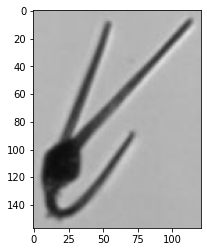

[45.5%] Thalassionema
[26.8%] Polychaeta_Larvae
[13.1%] Tripos
[8.3%] Chaetoceros
[0.9%] Pseudo-nitzschia


In [44]:
FILEPATH = './data/samples/random/Tripos_0B6AD65F-41F6-480B-AB23-2C1A02F992B1_494057.jpg'
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K, filemode='local')

plt.imshow(load_image(FILEPATH, filemode='local'))
plt.show()
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

#### Predict a list of local images

3/3 [==============================] - 1s 305ms/step


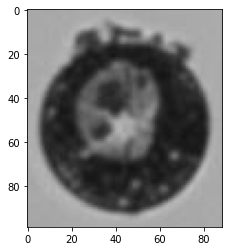

[32.8%] Centric_Diatom
[25.3%] Eggs
[8.1%] Stephanopyxis_turris
[5.3%] Actinoptychus_senarius
[5.1%] Guinardia_striata


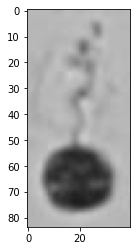

[27.2%] Guinardia_Dactyliosolen
[8.3%] Pleurosigma_Gyrosigma
[6.6%] Protoperidinium
[5.9%] Skeletonema
[5.7%] Ditylum_brightwellii


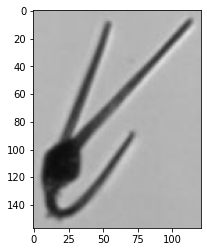

[62.0%] Thalassionema
[19.4%] Tripos
[7.3%] Polychaeta_Larvae
[5.5%] Chaetoceros
[0.9%] Pseudo-nitzschia


In [41]:
FILEPATHS = glob.glob('./data/samples/random/*')
     
pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='local')

for i, im_path in enumerate(FILEPATHS):
    plt.figure(i)
    plt.imshow(load_image(im_path, filemode='local'))
    plt.show()
    for j in range(pred_lab.shape[1]):
        print('[{:.1f}%] {}'.format(pred_prob[i, j] * 100, class_names[pred_lab[i, j]]))

#### Predict a list of local images belonging to the same observation

In this case all the images belong to the same observation so we wan to average the predictions among all of them.

In [40]:
FILEPATHS = glob.glob('./data/samples/tripos/*')
     
pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='local', merge=True)

for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

3/3 [==============================] - 1s 426ms/step
[30.5%] Tripos
[29.4%] Thalassionema
[7.8%] Favella_ehrenbergii
[7.5%] Trieres_sinensis
[7.1%] Chaetoceros


## Predicting image urls

#### Predict a single url

1/1 [==============================] - 0s 37ms/step


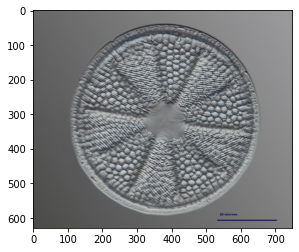

[87.0%] Noctiluca
[7.3%] Coscinodiscus_granii
[2.2%] Trieres_sinensis
[1.2%] Centric_Diatom
[0.4%] Artefacts


In [45]:
FILEPATH = 'https://forum.mikroscopia.com/uploads/monthly_07_2017/post-2056-0-71322100-1501364951_thumb.jpg'

pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K, filemode='url')

plt.imshow(load_image(FILEPATH, filemode='url'))
plt.show()
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

#### Predict a list of urls

2/2 [==============================] - 1s 292ms/step


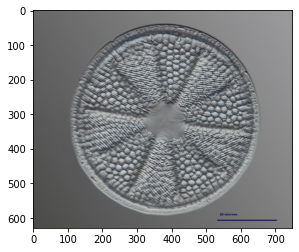

[83.4%] Noctiluca
[10.0%] Coscinodiscus_granii
[2.2%] Trieres_sinensis
[1.9%] Centric_Diatom
[0.5%] Artefacts


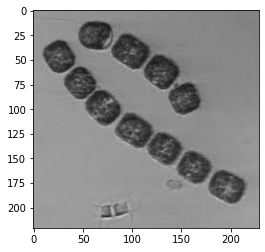

[22.6%] Stephanopyxis_turris
[20.5%] Thalassiosira_Porosira
[10.5%] Eucampia
[7.8%] Guinardia_striata
[5.6%] Meuniera_membranacea


In [46]:
FILEPATHS = ['https://forum.mikroscopia.com/uploads/monthly_07_2017/post-2056-0-71322100-1501364951_thumb.jpg',
             'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4SGFj2dBEobx3eWIo_J7inxK2aWvrQU9KQg&usqp=CAU']

pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='url')

for i, im_path in enumerate(FILEPATHS):
    plt.figure(i)
    plt.imshow(load_image(im_path, filemode='url'))
    plt.show()
    for j in range(pred_lab.shape[1]):
        print('[{:.1f}%] {}'.format(pred_prob[i, j] * 100, class_names[pred_lab[i, j]]))

#### Predict a list of local images belonging to the same observation

In this case all the images belong to the same observation so we wan to average the predictions among all of them.

In [47]:
FILEPATHS = ['https://forum.mikroscopia.com/uploads/monthly_07_2017/post-2056-0-71322100-1501364951_thumb.jpg',
             'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRXaZ8oFlnmkpm7_WpSX9Rj9HluA_m7fPdmlw&usqp=CAU']

pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='url', merge=True)

for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

2/2 [==============================] - 1s 269ms/step
[40.2%] Centric_Diatom
[37.3%] Noctiluca
[11.2%] Coscinodiscus_granii
[4.5%] Thalassiosira_Porosira
[2.4%] Trieres_sinensis


In [ ]:
# os.chdir("/srv/image_classification_tf")
# import os
# current_dir = os.getcwd()
# current_dir
# import os
# current_dir = os.getcwd()

# # Specify the folder name
# folder_name = "phyto-plankton-classification"

# # Construct the folder path
# folder_path = os.path.join(current_dir, folder_name)
# os.chdir(folder_path)
# print("Folder path:", folder_path)
# folder_path=current_dir
# print("Folder path:", folder_path)
# files = os.listdir(folder_path)
# print(files)